**LIBRERIE**

In [ ]:
!pip install -q sdv diffprivlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.6 MB/s eta 0:00:00


**CONFIGURAZIONE**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from scipy import stats

from sdv.single_table import CTGANSynthesizer
from sdv.metadata import Metadata

from diffprivlib.mechanisms import Laplace, LaplaceBoundedDomain
from diffprivlib.tools import mean, var, quantile

**Caricamento** e preprocessing

In [ ]:
def carica_dataset():
    url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
    df = pd.read_csv(url, header=None)
    df.columns = ['pregnancies', 'glucose', 'blood_pressure', 'skin_thickness',
                  'insulin', 'bmi', 'diabetes_pedigree', 'age', 'outcome']
    print("Dataset caricato da GitHub")
    return df

def preprocessa_dataset(df):
    cols_missing = ['glucose', 'blood_pressure', 'skin_thickness', 'insulin', 'bmi']
    df[cols_missing] = df[cols_missing].replace(0, np.nan)
    df[cols_missing] = df[cols_missing].fillna(df[cols_missing].median())
    return df

**Caricamento dati e split**

In [ ]:
df = carica_dataset()
df = preprocessa_dataset(df)

train_df, holdout_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['outcome'])

train_df.to_csv('./diabetes_train.csv', index=False)
holdout_df.to_csv('./diabetes_holdout.csv', index=False)

print(f"Dimensione train: {train_df.shape}")
print(f"Dimensione holdout: {holdout_df.shape}")

Dataset caricato da GitHub
Dimensione train: (537, 9)
Dimensione holdout: (231, 9)


Funzioni **DP**

In [ ]:
def add_laplace_noise_bounded(series, epsilon, lower, upper):
    """
    Applica rumore Laplace con dominio limitato usando diffprivlib.
    Questo garantisce che i valori rimangano nel range [lower, upper].
    """
    sensitivity = upper - lower
    mechanism = LaplaceBoundedDomain(epsilon=epsilon,
                                     sensitivity=sensitivity,
                                     lower=lower,
                                     upper=upper)
    noisy_values = np.array([mechanism.randomise(float(val)) for val in series.values])
    return pd.Series(noisy_values, index=series.index)

def applica_clipping_conservativo(df_synth, df_real):
    """Clipping finale basato su percentili."""
    df_clipped = df_synth.copy()

    for col in df_real.columns:
        if col == 'outcome':
            df_clipped[col] = df_clipped[col].round().clip(0, 1).astype(int)
            continue

        if col == 'glucose':
            lower = df_real[col].quantile(0.01)
            upper = df_real[col].quantile(0.99)
        elif col in ['pregnancies', 'age']:
            lower = max(0, df_real[col].min())
            upper = df_real[col].max() + 2
        else:
            lower = df_real[col].quantile(0.01)
            upper = df_real[col].quantile(0.99)

        df_clipped[col] = df_clipped[col].clip(lower, upper)

        if col in ['pregnancies', 'age', 'glucose', 'blood_pressure', 'skin_thickness', 'insulin']:
            df_clipped[col] = df_clipped[col].round().astype(int)

    return df_clipped

Funzione per la generazione dataset **sintetico**

In [ ]:
def genera_dataset_sintetico_diffprivlib(df_real, privacy_level='none'):
    """
    Generazione con privacy differenziale usando diffprivlib correttamente:
    1. CTGAN genera dati sintetici
    2. Se privacy: applica LaplaceBoundedDomain per ogni feature
    3. Clipping finale leggero
    """
    print(f"\n{'='*70}")
    print(f"Generazione dataset sintetico - Privacy: {privacy_level}")
    print(f"{'='*70}")

    metadata = Metadata.detect_from_dataframe(data=df_real)

    print("\nTraining CTGAN...")
    ctgan = CTGANSynthesizer(
        metadata,
        epochs=3000,
        batch_size=500,
        generator_dim=(256, 256, 256),
        discriminator_dim=(256, 256, 256),
        generator_lr=2e-4,
        discriminator_lr=2e-4,
        verbose=True,
        cuda=False
    )

    ctgan.fit(df_real)

    print("Generazione campioni...")
    df_synth = ctgan.sample(len(df_real))

    df_synth = applica_clipping_conservativo(df_synth, df_real)

    if privacy_level == 'moderate':
        epsilon = 5.0
        print(f"\nApplicazione rumore DP (Laplace Bounded) con epsilon={epsilon}")
        print("Usando LaplaceBoundedDomain di diffprivlib...\n")

        for col in df_synth.select_dtypes(include=[np.number]).columns:
            if col == 'outcome':
                continue

            lower = df_real[col].min()
            upper = df_real[col].max()

            if col not in ['pregnancies', 'age']:
                margin = (upper - lower) * 0.05
                lower -= margin
                upper += margin

            print(f"  {col:20s}: bounds=[{lower:7.1f}, {upper:7.1f}], epsilon={epsilon}")

            df_synth[col] = add_laplace_noise_bounded(
                df_synth[col],
                epsilon=epsilon,
                lower=lower,
                upper=upper
            )

        df_synth = applica_clipping_conservativo(df_synth, df_real)

    elif privacy_level == 'strong':
        epsilon = 1.0
        print(f"\nApplicazione rumore DP (Laplace Bounded) con epsilon={epsilon}")
        print("Usando LaplaceBoundedDomain di diffprivlib...\n")

        for col in df_synth.select_dtypes(include=[np.number]).columns:
            if col == 'outcome':
                continue

            lower = df_real[col].min()
            upper = df_real[col].max()

            if col not in ['pregnancies', 'age']:
                margin = (upper - lower) * 0.05
                lower -= margin
                upper += margin

            print(f"  {col:20s}: bounds=[{lower:7.1f}, {upper:7.1f}], epsilon={epsilon}")

            df_synth[col] = add_laplace_noise_bounded(
                df_synth[col],
                epsilon=epsilon,
                lower=lower,
                upper=upper
            )

        df_synth = applica_clipping_conservativo(df_synth, df_real)

    print("\n" + "="*70)
    print("CONTROLLO FINALE - Range e statistiche:")
    print("="*70)
    print(f"{'Feature':<20} {'Real Range':<25} {'Synth Range':<25} {'Real Mean':<12} {'Synth Mean'}")
    print("-"*70)

    for col in df_real.select_dtypes(include=[np.number]).columns:
        real_min, real_max = df_real[col].min(), df_real[col].max()
        synth_min, synth_max = df_synth[col].min(), df_synth[col].max()
        real_mean, synth_mean = df_real[col].mean(), df_synth[col].mean()

        real_range = f"[{real_min:6.1f}, {real_max:6.1f}]"
        synth_range = f"[{synth_min:6.1f}, {synth_max:6.1f}]"

        print(f"{col:<20} {real_range:<25} {synth_range:<25} {real_mean:6.1f}      {synth_mean:6.1f}")

    return df_synth, metadata

Generazione dataset sintetico con no privacy, privacy moderate e strong

In [ ]:
print("\n" + "="*80)
print("GENERAZIONE DATASET SINTETICO - NO PRIVACY")
print("="*80)

synthetic_noprivacy, metadata_noprivacy = genera_dataset_sintetico_diffprivlib(train_df, privacy_level='none')
synthetic_noprivacy.to_csv('./synthetic_no_privacy.csv', index=False)
print("\n" + "="*80)
print("GENERAZIONE DATASET SINTETICO - PRIVACY MODERATA")
print("="*80)

synthetic_mod, metadata_mod = genera_dataset_sintetico_diffprivlib(train_df, privacy_level='moderate')
synthetic_mod.to_csv('./synthetic_privacy_moderate.csv', index=False)
print("\n" + "="*80)
print("GENERAZIONE DATASET SINTETICO - PRIVACY FORTE")
print("="*80)

synthetic_strong, metadata_strong = genera_dataset_sintetico_diffprivlib(train_df, privacy_level='strong')
synthetic_strong.to_csv('./synthetic_privacy_strong.csv', index=False)


GENERAZIONE DATASET SINTETICO - NO PRIVACY

Generazione dataset sintetico - Privacy: none

Training CTGAN...


Gen. (-3.68) | Discrim. (0.18): 100%|██████████| 3000/3000 [06:05<00:00,  8.21it/s]


Generazione campioni...

CONTROLLO FINALE - Range e statistiche:
Feature              Real Range                Synth Range               Real Mean    Synth Mean
----------------------------------------------------------------------
pregnancies          [   0.0,   17.0]          [   0.0,   13.0]             3.9         2.9
glucose              [  57.0,  198.0]          [  71.0,  195.0]           121.6       133.7
blood_pressure       [  24.0,  122.0]          [  44.0,  107.0]            72.2        64.9
skin_thickness       [   7.0,   60.0]          [  10.0,   48.0]            28.9        26.6
insulin              [  16.0,  744.0]          [  26.0,  505.0]           138.1       144.2
bmi                  [  18.2,   67.1]          [  19.4,   51.1]            32.6        30.2
diabetes_pedigree    [   0.1,    2.3]          [   0.1,    1.7]             0.5         0.5
age                  [  21.0,   81.0]          [  21.0,   62.0]            33.6        33.3
outcome              [   0.0,  

Gen. (-3.71) | Discrim. (0.15): 100%|██████████| 3000/3000 [06:01<00:00,  8.29it/s]


Generazione campioni...

Applicazione rumore DP (Laplace Bounded) con epsilon=5.0
Usando LaplaceBoundedDomain di diffprivlib...

  pregnancies         : bounds=[    0.0,    17.0], epsilon=5.0
  glucose             : bounds=[   50.0,   205.1], epsilon=5.0
  blood_pressure      : bounds=[   19.1,   126.9], epsilon=5.0
  skin_thickness      : bounds=[    4.3,    62.6], epsilon=5.0
  insulin             : bounds=[  -20.4,   780.4], epsilon=5.0
  bmi                 : bounds=[   15.8,    69.5], epsilon=5.0
  diabetes_pedigree   : bounds=[   -0.0,     2.4], epsilon=5.0
  age                 : bounds=[   21.0,    81.0], epsilon=5.0

CONTROLLO FINALE - Range e statistiche:
Feature              Real Range                Synth Range               Real Mean    Synth Mean
----------------------------------------------------------------------
pregnancies          [   0.0,   17.0]          [   0.0,   17.0]             3.9         5.9
glucose              [  57.0,  198.0]          [  71.0,  195.0]   

Gen. (-3.67) | Discrim. (0.13): 100%|██████████| 3000/3000 [06:11<00:00,  8.07it/s]


Generazione campioni...

Applicazione rumore DP (Laplace Bounded) con epsilon=1.0
Usando LaplaceBoundedDomain di diffprivlib...

  pregnancies         : bounds=[    0.0,    17.0], epsilon=1.0
  glucose             : bounds=[   50.0,   205.1], epsilon=1.0
  blood_pressure      : bounds=[   19.1,   126.9], epsilon=1.0
  skin_thickness      : bounds=[    4.3,    62.6], epsilon=1.0
  insulin             : bounds=[  -20.4,   780.4], epsilon=1.0
  bmi                 : bounds=[   15.8,    69.5], epsilon=1.0
  diabetes_pedigree   : bounds=[   -0.0,     2.4], epsilon=1.0
  age                 : bounds=[   21.0,    81.0], epsilon=1.0

CONTROLLO FINALE - Range e statistiche:
Feature              Real Range                Synth Range               Real Mean    Synth Mean
----------------------------------------------------------------------
pregnancies          [   0.0,   17.0]          [   0.0,   17.0]             3.9         8.4
glucose              [  57.0,  198.0]          [  71.0,  195.0]   

Funzione analisi **qualità**

In [ ]:
def analisi_completa(real, synth, nome):
    """Analisi dettagliata della qualità dei dati sintetici."""
    print(f"\n{'='*70}")
    print(f"ANALISI: {nome}")
    print(f"{'='*70}")

    # 2. Statistiche descrittive
    print("\n--- STATISTICHE DESCRITTIVE ---")
    comparison = []

    for col in real.select_dtypes(include=[np.number]).columns:
        real_mean = real[col].mean()
        synth_mean = synth[col].mean()
        real_std = real[col].std()
        synth_std = synth[col].std()

        mean_error = abs(real_mean - synth_mean) / real_mean * 100
        std_error = abs(real_std - synth_std) / real_std * 100

        comparison.append({
            'Feature': col,
            'Real_Mean': f"{real_mean:.1f}",
            'Synth_Mean': f"{synth_mean:.1f}",
            'Mean_Err%': f"{mean_error:.1f}",
            'Real_Std': f"{real_std:.1f}",
            'Synth_Std': f"{synth_std:.1f}",
            'Std_Err%': f"{std_error:.1f}"
        })

    comp_df = pd.DataFrame(comparison)
    print(comp_df.to_string(index=False))

    # 3. Correlazioni
    print("\n--- PRESERVAZIONE CORRELAZIONI ---")
    real_corr = real.select_dtypes(include=[np.number]).corr()
    synth_corr = synth.select_dtypes(include=[np.number]).corr()
    corr_diff = abs(real_corr - synth_corr)

    print(f"Differenza media: {corr_diff.mean().mean():.4f}")
    print(f"Differenza max: {corr_diff.max().max():.4f}")

    # 4. Visualizzazioni - Solo distribuzioni e correlazioni
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # ROW 1: Distribuzioni principali
    ax1 = axes[0, 0]
    ax1.hist(real['glucose'], bins=30, alpha=0.6, label='Reale',
             color='blue', density=True, edgecolor='black')
    ax1.hist(synth['glucose'], bins=30, alpha=0.6, label='Sintetico',
             color='red', density=True, edgecolor='black')
    ax1.set_title('Distribuzione Glucosio', fontweight='bold', fontsize=12)
    ax1.set_xlabel('Glucosio (mg/dL)')
    ax1.set_ylabel('Densità')
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2 = axes[0, 1]
    ax2.hist(real['bmi'], bins=30, alpha=0.6, label='Reale',
             color='blue', density=True, edgecolor='black')
    ax2.hist(synth['bmi'], bins=30, alpha=0.6, label='Sintetico',
             color='red', density=True, edgecolor='black')
    ax2.set_title('Distribuzione BMI', fontweight='bold', fontsize=12)
    ax2.set_xlabel('BMI')
    ax2.set_ylabel('Densità')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # ROW 2: Correlazioni
    ax3 = axes[1, 0]
    sns.heatmap(real_corr, annot=True, cmap='coolwarm', center=0,
                vmin=-1, vmax=1, ax=ax3, cbar_kws={'shrink': 0.8}, fmt='.2f')
    ax3.set_title('Correlazioni Reali', fontweight='bold', fontsize=12)

    ax4 = axes[1, 1]
    sns.heatmap(synth_corr, annot=True, cmap='coolwarm', center=0,
                vmin=-1, vmax=1, ax=ax4, cbar_kws={'shrink': 0.8}, fmt='.2f')
    ax4.set_title('Correlazioni Sintetiche', fontweight='bold', fontsize=12)

    plt.suptitle(f'Analisi Qualità - {nome}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return comp_df

**Analisi**


ANALISI: NO PRIVACY

--- STATISTICHE DESCRITTIVE ---
          Feature Real_Mean Synth_Mean Mean_Err% Real_Std Synth_Std Std_Err%
      pregnancies       3.9        2.9      26.3      3.4       2.6     21.2
          glucose     121.6      133.7      10.0     30.0      32.5      8.7
   blood_pressure      72.2       64.9      10.2     12.2       9.8     20.0
   skin_thickness      28.9       26.6       7.8      8.3       7.7      6.6
          insulin     138.1      144.2       4.5     79.7      59.3     25.6
              bmi      32.6       30.2       7.4      6.7       6.6      1.7
diabetes_pedigree       0.5        0.5       6.3      0.3       0.4      7.9
              age      33.6       33.3       0.8     11.8      11.5      2.1
          outcome       0.3        0.5      36.4      0.5       0.5      4.8

--- PRESERVAZIONE CORRELAZIONI ---
Differenza media: 0.0807
Differenza max: 0.2502


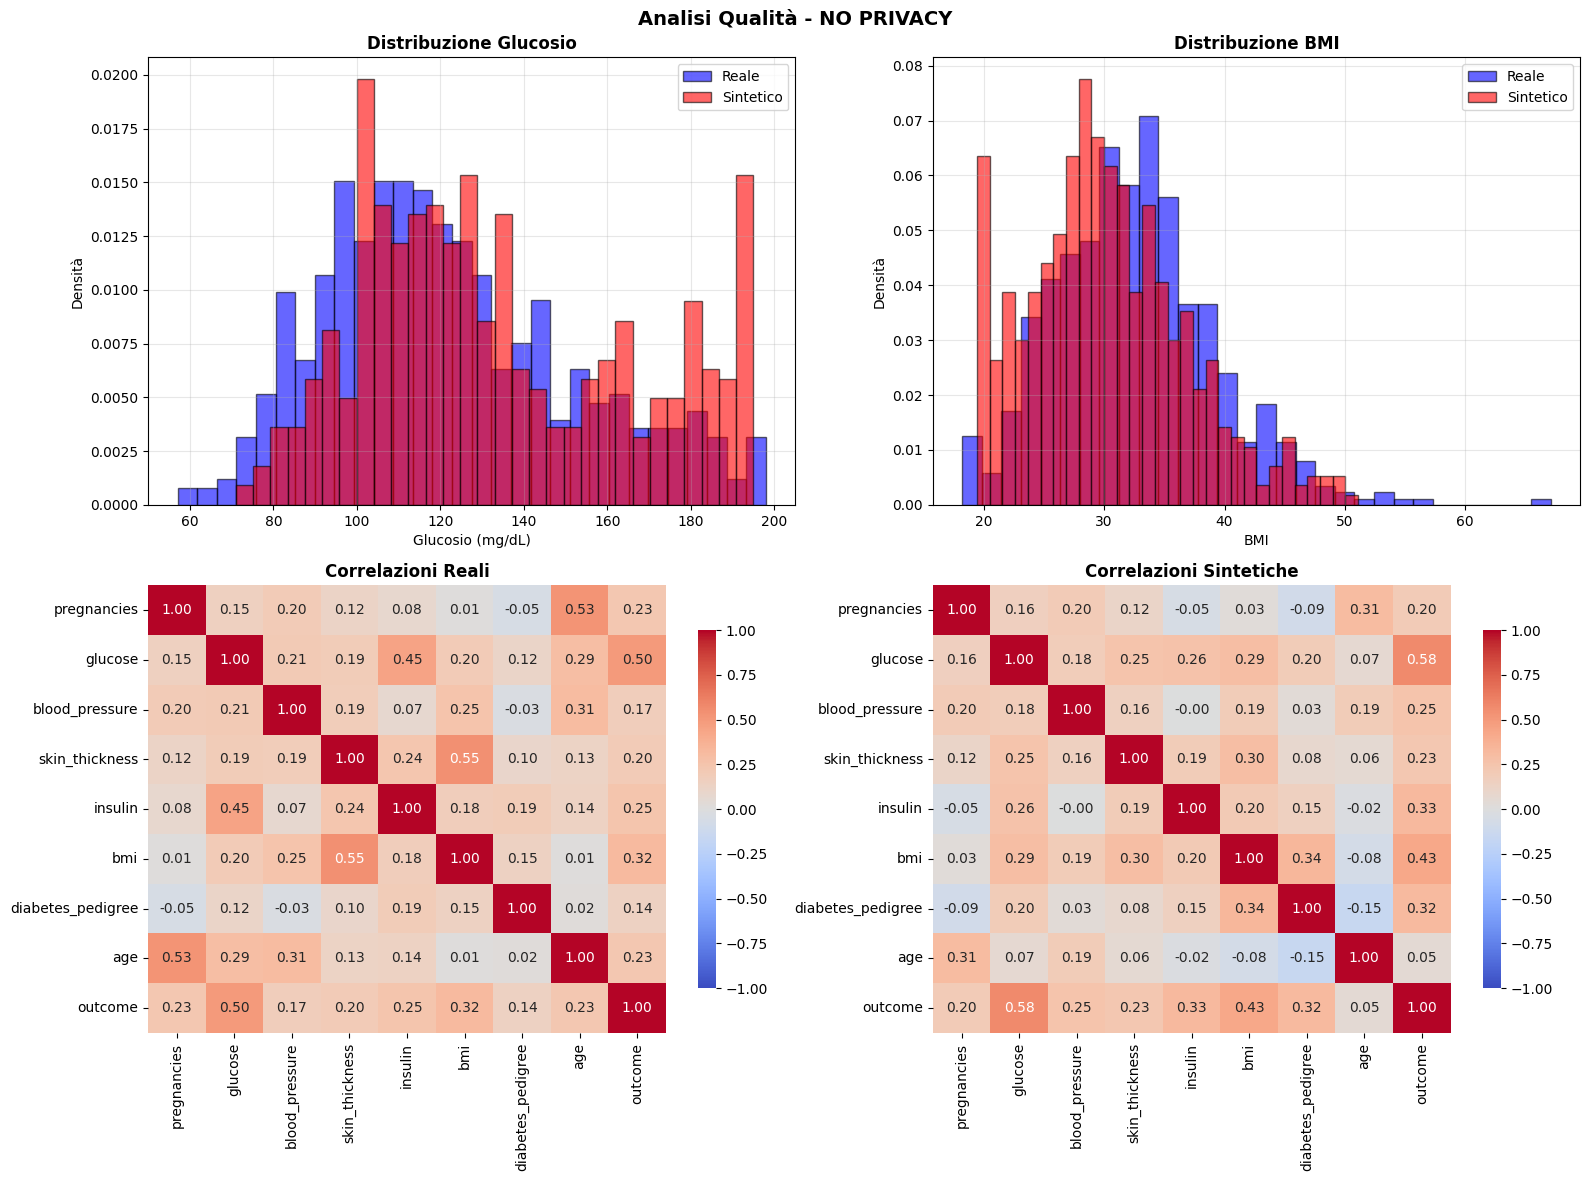


ANALISI: PRIVACY MODERATA (ε=5.0)

--- STATISTICHE DESCRITTIVE ---
          Feature Real_Mean Synth_Mean Mean_Err% Real_Std Synth_Std Std_Err%
      pregnancies       3.9        5.9      53.0      3.4       4.0     18.1
          glucose     121.6      124.1       2.1     30.0      35.6     18.7
   blood_pressure      72.2       76.8       6.3     12.2      19.7     61.3
   skin_thickness      28.9       31.1       7.8      8.3      11.6     40.2
          insulin     138.1      219.1      58.7     79.7     151.1     89.5
              bmi      32.6       34.8       6.6      6.7       9.8     45.0
diabetes_pedigree       0.5        0.7      40.9      0.3       0.5     38.4
              age      33.6       39.1      16.5     11.8      12.8      8.4
          outcome       0.3        0.5      36.4      0.5       0.5      4.8

--- PRESERVAZIONE CORRELAZIONI ---
Differenza media: 0.1602
Differenza max: 0.5364


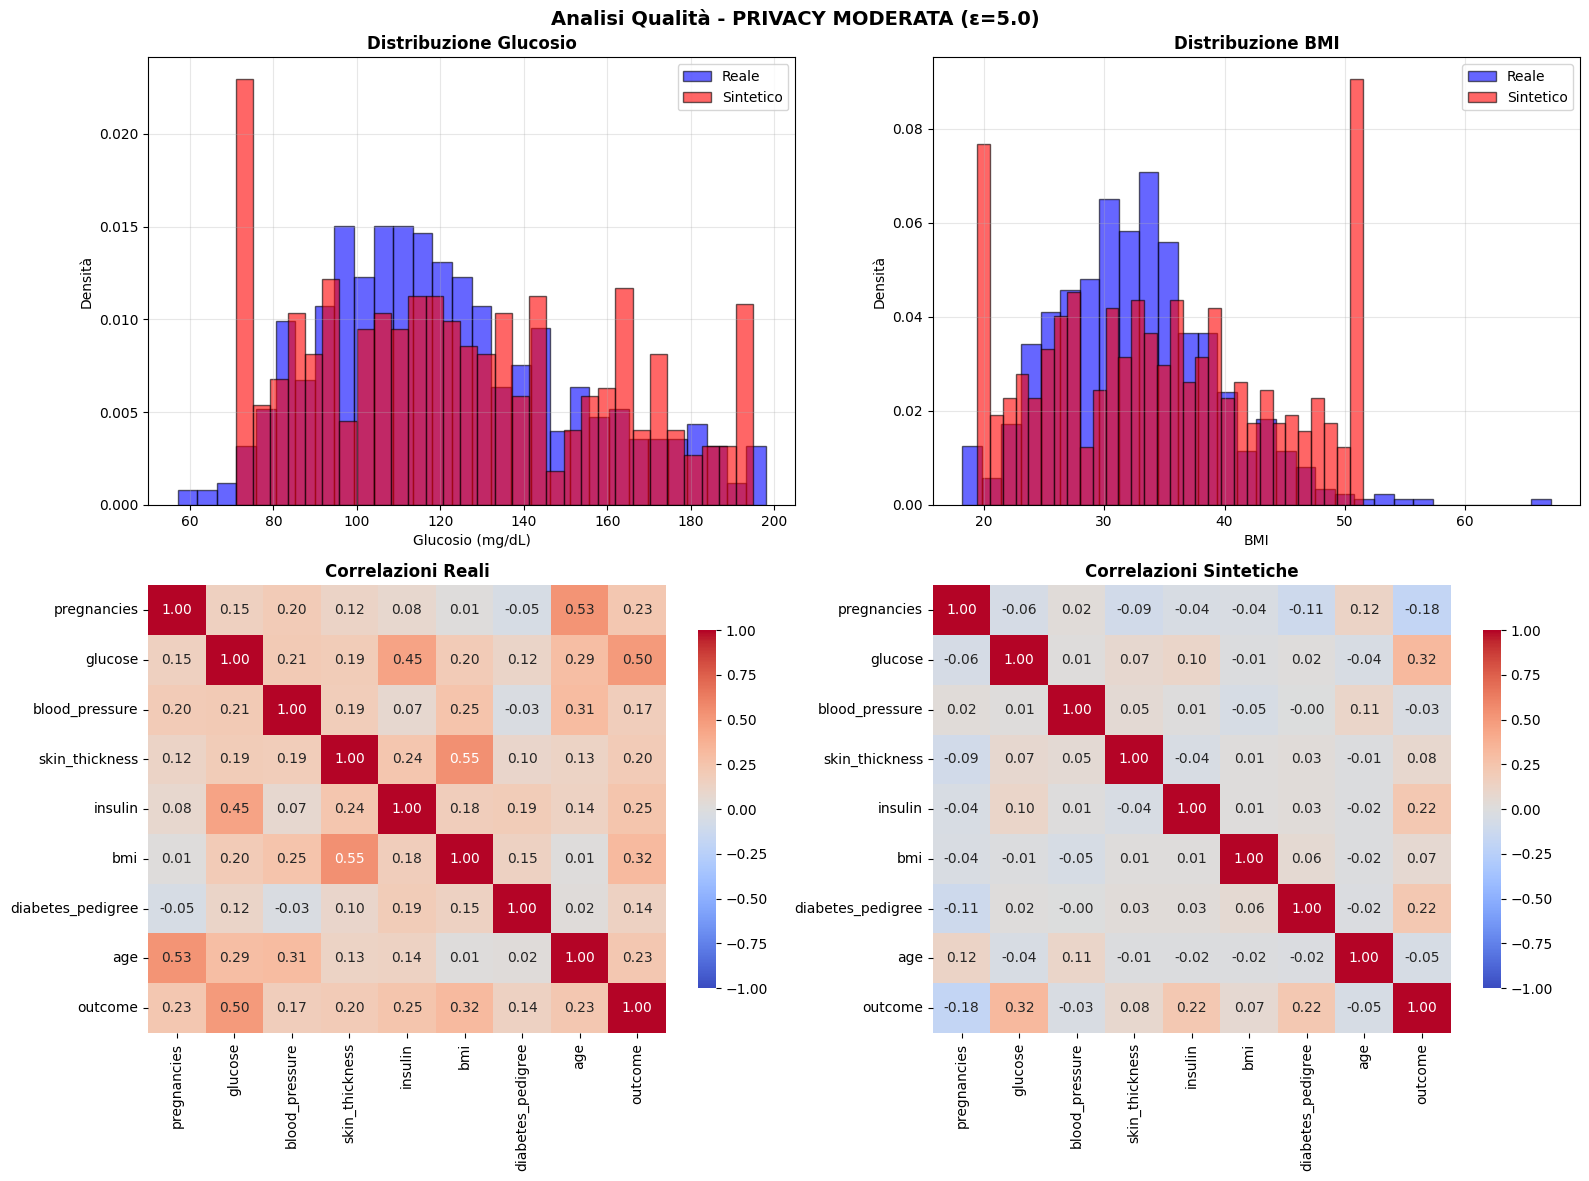


ANALISI: PRIVACY FORTE (ε=1.0)

--- STATISTICHE DESCRITTIVE ---
          Feature Real_Mean Synth_Mean Mean_Err% Real_Std Synth_Std Std_Err%
      pregnancies       3.9        8.4     115.7      3.4       4.8     42.2
          glucose     121.6      129.4       6.4     30.0      41.5     38.6
   blood_pressure      72.2       75.7       4.8     12.2      24.1     97.6
   skin_thickness      28.9       31.9      10.5      8.3      14.1     70.1
          insulin     138.1      296.7     114.9     79.7     176.6    121.6
              bmi      32.6       38.0      16.4      6.7      11.4     69.3
diabetes_pedigree       0.5        1.1     123.3      0.3       0.6     67.8
              age      33.6       46.8      39.6     11.8      16.9     42.9
          outcome       0.3        0.5      36.4      0.5       0.5      4.8

--- PRESERVAZIONE CORRELAZIONI ---
Differenza media: 0.1640
Differenza max: 0.5581


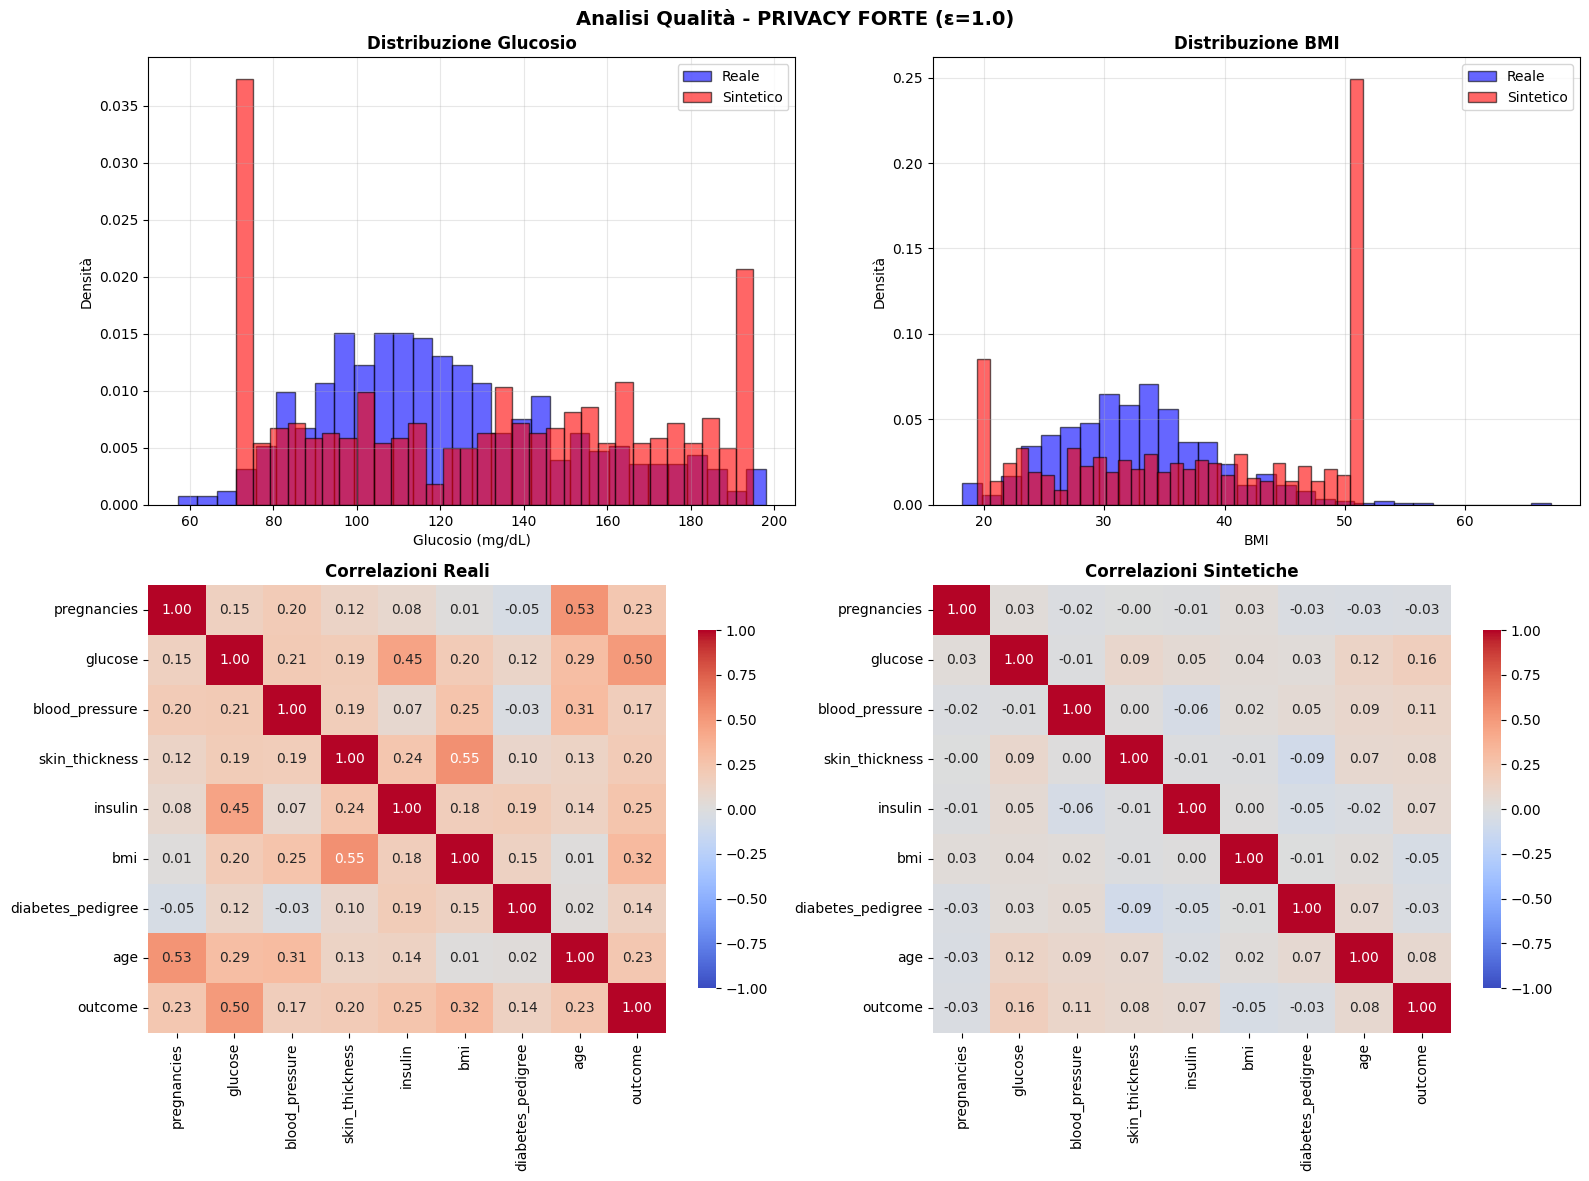

In [ ]:
datasets = [
    ("NO PRIVACY", synthetic_noprivacy),
    ("PRIVACY MODERATA (ε=5.0)", synthetic_mod),
    ("PRIVACY FORTE (ε=1.0)", synthetic_strong)
]

risultati_qualita = {}
for nome, synth_df in datasets:
    comp_df = analisi_completa(train_df, synth_df, nome)
    risultati_qualita[nome] = comp_df

modelli

In [ ]:
def valuta_modello(y_true, y_pred, y_pred_proba, nome):
    risultati = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }

    print(f"\n{nome}:")
    for metric, value in risultati.items():
        print(f"  {metric}: {value:.4f}")

    return risultati

print("\n" + "="*80)
print("VALUTAZIONE UTILITÀ: MODELLI PREDITTIVI")
print("="*80)

X_test = holdout_df.drop('outcome', axis=1)
y_test = holdout_df['outcome']

# Baseline: Dati Reali
print("\n--- BASELINE: DATI REALI ---")
X_train_real = train_df.drop('outcome', axis=1)
y_train_real = train_df['outcome']

risultati_modelli = {}

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_real, y_train_real)
risultati_modelli['Real_LR'] = valuta_modello(
    y_test, lr.predict(X_test), lr.predict_proba(X_test)[:, 1],
    "Logistic Regression (Real)"
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_real, y_train_real)
risultati_modelli['Real_RF'] = valuta_modello(
    y_test, rf.predict(X_test), rf.predict_proba(X_test)[:, 1],
    "Random Forest (Real)"
)

# Modelli su dati sintetici
for nome, synth_df in datasets:
    print(f"\n--- {nome} ---")
    X_train_synth = synth_df.drop('outcome', axis=1)
    y_train_synth = synth_df['outcome']

    lr_s = LogisticRegression(max_iter=1000, random_state=42)
    lr_s.fit(X_train_synth, y_train_synth)
    key = nome.replace(' ', '_').replace('(', '').replace(')', '').replace('=', '').replace('.', '').replace('ε', 'eps')
    risultati_modelli[f'{key}_LR'] = valuta_modello(
        y_test, lr_s.predict(X_test), lr_s.predict_proba(X_test)[:, 1],
        f"LR ({nome})"
    )

    rf_s = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_s.fit(X_train_synth, y_train_synth)
    risultati_modelli[f'{key}_RF'] = valuta_modello(
        y_test, rf_s.predict(X_test), rf_s.predict_proba(X_test)[:, 1],
        f"RF ({nome})"
    )


VALUTAZIONE UTILITÀ: MODELLI PREDITTIVI

--- BASELINE: DATI REALI ---

Logistic Regression (Real):
  Accuracy: 0.7446
  Precision: 0.6719
  Recall: 0.5309
  F1-Score: 0.5931
  ROC-AUC: 0.8346

Random Forest (Real):
  Accuracy: 0.7403
  Precision: 0.6667
  Recall: 0.5185
  F1-Score: 0.5833
  ROC-AUC: 0.8159

--- NO_PRIVACY ---

LR (NO_PRIVACY):
  Accuracy: 0.7100
  Precision: 0.5636
  Recall: 0.7654
  F1-Score: 0.6492
  ROC-AUC: 0.8002

RF (NO_PRIVACY):
  Accuracy: 0.7143
  Precision: 0.5758
  Recall: 0.7037
  F1-Score: 0.6333
  ROC-AUC: 0.7901

--- PRIVACY_MODERATA ---

LR (PRIVACY_MODERATA):
  Accuracy: 0.7359
  Precision: 0.6562
  Recall: 0.5185
  F1-Score: 0.5793
  ROC-AUC: 0.7550

RF (PRIVACY_MODERATA):
  Accuracy: 0.7143
  Precision: 0.6027
  Recall: 0.5432
  F1-Score: 0.5714
  ROC-AUC: 0.7276

--- PRIVACY_FORTE ---

LR (PRIVACY_FORTE):
  Accuracy: 0.7100
  Precision: 0.6129
  Recall: 0.4691
  F1-Score: 0.5315
  ROC-AUC: 0.7573

RF (PRIVACY_FORTE):
  Accuracy: 0.6407
  Precision:

Confronto finale


CONFRONTO FINALE - TABELLA RIASSUNTIVA

                      Accuracy  Precision  Recall  F1-Score  ROC-AUC
Real_LR                0.7446     0.6719  0.5309    0.5931   0.8346
Real_RF                0.7403     0.6667  0.5185    0.5833   0.8159
NO_PRIVACY_LR          0.7100     0.5636  0.7654    0.6492   0.8002
NO_PRIVACY_RF          0.7143     0.5758  0.7037    0.6333   0.7901
PRIVACY_MODERATA_LR    0.7359     0.6562  0.5185    0.5793   0.7550
PRIVACY_MODERATA_RF    0.7143     0.6027  0.5432    0.5714   0.7276
PRIVACY_FORTE_LR       0.7100     0.6129  0.4691    0.5315   0.7573
PRIVACY_FORTE_RF       0.6407     0.4844  0.3827    0.4276   0.5980


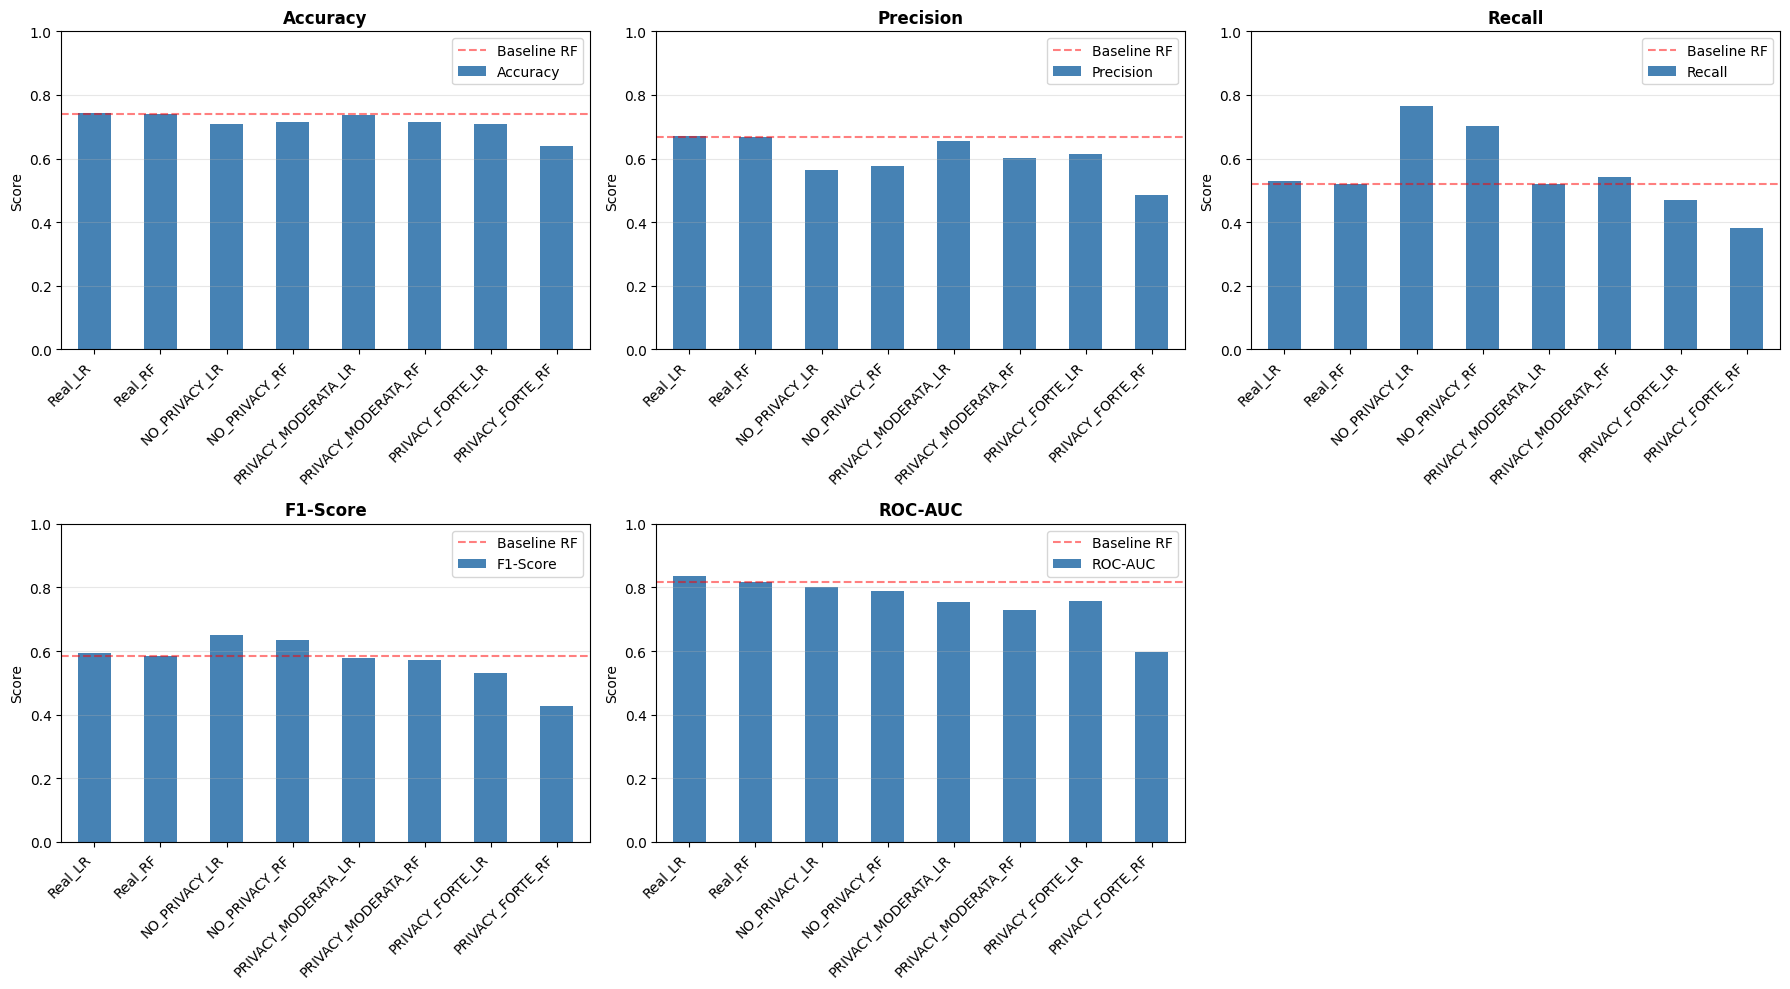

In [ ]:
print("\n" + "="*80)
print("CONFRONTO FINALE - TABELLA RIASSUNTIVA")
print("="*80)

risultati_df = pd.DataFrame(risultati_modelli).T
risultati_df = risultati_df.round(4)
print("\n", risultati_df.to_string())

# Grafico comparativo
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
metriche = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metrica in enumerate(metriche):
    ax = axes[idx // 3, idx % 3]
    risultati_df[metrica].plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title(metrica, fontsize=12, fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    ax.axhline(y=risultati_df.loc['Real_RF', metrica], color='red',
               linestyle='--', alpha=0.5, label='Baseline RF')
    ax.legend()

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('confronto_finale_diffprivlib.png', dpi=300, bbox_inches='tight')
plt.show()

altri modelli

In [ ]:
# ============================================================================
# TEST DI UTILITÀ PER LA RICERCA
# Addestramento di modelli di previsione malattie su dati sintetici
# e valutazione su un set reale di test
# ============================================================================

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False

try:
    from lightgbm import LGBMClassifier
    lgbm_available = True
except:
    lgbm_available = False

# ============================
# 1. Dataset reale di test
# ============================
X_test = holdout_df.drop('outcome', axis=1)
y_test = holdout_df['outcome']

# ============================
# 2. Funzione valutazione
# ============================
def valuta_modello(y_true, y_pred, y_pred_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba)
    }

# ============================
# 3. Modelli da testare
# ============================
risultati = {}

model_zoo = {
    "LR": LogisticRegression(max_iter=1000, random_state=42),
    "RF": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "GB": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42),
    "ADA": AdaBoostClassifier(n_estimators=100, learning_rate=0.5, random_state=42),
    "DT": DecisionTreeClassifier(max_depth=10, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "NB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

if xgb_available:
    model_zoo["XGB"] = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                                     random_state=42, eval_metric='logloss')

if lgbm_available:
    model_zoo["LGBM"] = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                                       random_state=42, verbose=-1)

# Dataset sintetici da confrontare
datasets = [
    ("NO_PRIVACY", synthetic_noprivacy),
    ("PRIVACY_MODERATA", synthetic_mod),
    ("PRIVACY_FORTE", synthetic_strong)
]

# ============================
# 4. Addestramento su dati sintetici
#    Valutazione su dati reali
# ============================
for dataset_name, synth_df in datasets:

    print(f"\n{'='*70}")
    print(f"Training su dataset sintetico: {dataset_name}")
    print('='*70)

    X_train = synth_df.drop('outcome', axis=1)
    y_train = synth_df['outcome']

    for model_name, model in model_zoo.items():

        # Addestramento SU DATI SINTETICI
        model.fit(X_train, y_train)

        # Valutazione SU DATI REALI
        pred = model.predict(X_test)
        pred_proba = model.predict_proba(X_test)[:, 1]

        risultati[f"{dataset_name}_{model_name}"] = valuta_modello(y_test, pred, pred_proba)

# ============================
# 5. Risultati finali
# ============================
import pandas as pd

print(f"\n{'='*80}")
print("CONFRONTO FINALE — PERFORMANCE SU DATI REALI")
print('='*80)

df_risultati = pd.DataFrame(risultati).T.round(4)
print(df_risultati.to_string())

# ============================
# 6. Migliori modelli per metrica
# ============================
print(f"\n{'='*80}")
print("MIGLIORI MODELLI PER METRICA")
print('='*80)

for m in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best = df_risultati[m].idxmax()
    value = df_risultati[m].max()
    print(f"{m}: {best} = {value:.4f}")

print(f"\n{'='*80}")
print("Analisi completata")
print('='*80)



Training su dataset sintetico: NO_PRIVACY

Training su dataset sintetico: PRIVACY_MODERATA

Training su dataset sintetico: PRIVACY_FORTE

CONFRONTO FINALE — PERFORMANCE SU DATI REALI
                       Accuracy  Precision  Recall  F1-Score  ROC-AUC
NO_PRIVACY_LR            0.7100     0.5636  0.7654    0.6492   0.8002
NO_PRIVACY_RF            0.7100     0.5700  0.7037    0.6298   0.7827
NO_PRIVACY_GB            0.6970     0.5567  0.6667    0.6067   0.7761
NO_PRIVACY_ADA           0.7056     0.5699  0.6543    0.6092   0.7958
NO_PRIVACY_DT            0.6710     0.5248  0.6543    0.5824   0.6788
NO_PRIVACY_SVM           0.7013     0.5714  0.5926    0.5818   0.7911
NO_PRIVACY_KNN           0.6797     0.5368  0.6296    0.5795   0.7409
NO_PRIVACY_NB            0.6623     0.5126  0.7531    0.6100   0.7554
NO_PRIVACY_MLP           0.6234     0.4712  0.6049    0.5297   0.6317
NO_PRIVACY_XGB           0.6970     0.5545  0.6914    0.6154   0.7869
NO_PRIVACY_LGBM          0.7143     0.5824  0.

L’analisi confronta diversi modelli predittivi addestrati su tre versioni di dataset sintetici, **senza privacy**, **con privacy moderata** e **con privacy forte**, valutandone le prestazioni su un set reale di test. I risultati mostrano che i modelli addestrati su dati sintetici **senza privacy** e **con privacy moderata** ottengono performance complessivamente buone e comparabili, con valori di Accuracy tipicamente compresi tra 0.70 e 0.76 e ROC-AUC tra 0.79 e 0.83. Ciò indica che questi dataset sintetici conservano una quantità sufficiente di informazione strutturale per permettere ai modelli di generalizzare bene sui dati reali.

In particolare, i modelli addestrati su **privacy moderata** ottengono in più casi le migliori metriche, suggerendo un buon equilibrio tra tutela della privacy e qualità statistica del dato. Modelli come Logistic Regression, AdaBoost e Naive Bayes mostrano prestazioni robuste in questo scenario, con ROC-AUC fino a 0.83.

Al contrario, i modelli addestrati sui dati con **privacy forte** presentano un netto peggioramento delle performance. Accuracy e F1-score calano in modo significativo, e diversi modelli mostrano recall molto bassi, segnale che l’informazione utile alla predizione è stata in parte compromessa dall’applicazione di un livello di privacy troppo elevato.

In conclusione, la privacy moderata offre il miglior compromesso, mentre livelli troppo elevati degradano sensibilmente l’utilità analitica del dato.


In [ ]:
print("\n" + "="*80)
print("TEST DI PRIVACY: MEMBERSHIP INFERENCE ATTACK")
print("="*80)
print("\nApproccio corretto: addestra modelli su dati sintetici, poi verifica")
print("se riescono a distinguere record che ERANO nel training originale da")
print("record che NON erano nel training originale.\n")

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# ============================================================================
# APPROCCIO CORRETTO
# ============================================================================
#
# PROBLEMA con approccio precedente:
# - Sbilanciamento 537 vs 231 → attaccante predice sempre "membro" → 70% acc
#
# SOLUZIONE:
# 1. Bilancia perfettamente membri/non-membri (stesso numero)
# 2. Usa cross-validation per risultati stabili
# 3. Penalizza predizioni sbilanciate (weighted classes)
# 4. Misura su holdout bilanciato separato
# ============================================================================

def membership_inference_attack_bilanciato(shadow_model, train_original, test_original):
    """
    Attacco di membership inference con dataset PERFETTAMENTE BILANCIATO.
    Questo elimina il problema dello sbilanciamento che gonfiava artificialmente l'accuracy.
    """

    # STEP 1: Bilancia i dataset - stesso numero di membri e non-membri
    n_samples = min(len(train_original), len(test_original))

    membri = train_original.sample(n=n_samples, random_state=42)
    non_membri = test_original.sample(n=n_samples, random_state=42)

    print(f"  Dataset bilanciato: {n_samples} membri + {n_samples} non-membri = {2*n_samples} totali")

    # STEP 2: Estrai feature dalle predizioni del shadow model
    X_membri = membri.drop('outcome', axis=1)
    y_membri = membri['outcome']

    X_non_membri = non_membri.drop('outcome', axis=1)
    y_non_membri = non_membri['outcome']

    # Predizioni del shadow model
    pred_membri = shadow_model.predict_proba(X_membri)
    pred_non_membri = shadow_model.predict_proba(X_non_membri)

    # Feature per l'attacco
    features_membri = []
    for i in range(len(pred_membri)):
        probs = pred_membri[i]
        true_label = y_membri.iloc[i]

        features_membri.append({
            'confidence': np.max(probs),
            'entropy': -np.sum(probs * np.log(probs + 1e-10)),
            'prob_true_class': probs[true_label],
            'margin': probs[np.argsort(probs)[-1]] - probs[np.argsort(probs)[-2]] if len(probs) > 1 else probs[0]
        })

    features_non_membri = []
    for i in range(len(pred_non_membri)):
        probs = pred_non_membri[i]
        true_label = y_non_membri.iloc[i]

        features_non_membri.append({
            'confidence': np.max(probs),
            'entropy': -np.sum(probs * np.log(probs + 1e-10)),
            'prob_true_class': probs[true_label],
            'margin': probs[np.argsort(probs)[-1]] - probs[np.argsort(probs)[-2]] if len(probs) > 1 else probs[0]
        })

    X_attack = pd.DataFrame(features_membri + features_non_membri)
    y_attack = np.array([1] * len(features_membri) + [0] * len(features_non_membri))

    # STEP 3: Normalizza le feature
    scaler = StandardScaler()
    X_attack_scaled = scaler.fit_transform(X_attack)
    X_attack_scaled = pd.DataFrame(X_attack_scaled, columns=X_attack.columns)

    # STEP 4: Cross-validation stratificata per risultati robusti
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results_cv = {
        'accuracy': [],
        'auc': [],
        'precision': [],
        'recall': []
    }

    for train_idx, test_idx in cv.split(X_attack_scaled, y_attack):
        X_train_cv = X_attack_scaled.iloc[train_idx]
        y_train_cv = y_attack[train_idx]
        X_test_cv = X_attack_scaled.iloc[test_idx]
        y_test_cv = y_attack[test_idx]

        # Attaccante con class_weight per evitare bias
        attacker = LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced',  # IMPORTANTE: bilancia le classi
            C=1.0
        )
        attacker.fit(X_train_cv, y_train_cv)

        y_pred = attacker.predict(X_test_cv)
        y_proba = attacker.predict_proba(X_test_cv)[:, 1]

        results_cv['accuracy'].append(accuracy_score(y_test_cv, y_pred))
        results_cv['auc'].append(roc_auc_score(y_test_cv, y_proba))
        results_cv['precision'].append(precision_score(y_test_cv, y_pred, zero_division=0))
        results_cv['recall'].append(recall_score(y_test_cv, y_pred, zero_division=0))

    # Media dei risultati
    accuracy_mean = np.mean(results_cv['accuracy'])
    accuracy_std = np.std(results_cv['accuracy'])
    auc_mean = np.mean(results_cv['auc'])
    auc_std = np.std(results_cv['auc'])
    precision_mean = np.mean(results_cv['precision'])
    recall_mean = np.mean(results_cv['recall'])

    # Privacy Risk
    privacy_risk = (accuracy_mean - 0.5) * 200

    return {
        'accuracy': accuracy_mean,
        'accuracy_std': accuracy_std,
        'auc': auc_mean,
        'auc_std': auc_std,
        'precision': precision_mean,
        'recall': recall_mean,
        'privacy_risk': privacy_risk,
        'n_samples': 2 * n_samples
    }


# ============================================================================
# FASE 1: BASELINE - MODELLO SU DATI ORIGINALI
# ============================================================================

print("="*80)
print("FASE 1: Baseline - Modello addestrato su dati ORIGINALI")
print("="*80)
print("Misura se il modello memorizza i record del training.\n")

X_train_orig = train_df.drop('outcome', axis=1)
y_train_orig = train_df['outcome']

# Modello con capacita di memorizzazione moderata
baseline_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42
)
baseline_model.fit(X_train_orig, y_train_orig)

print(f"Modello baseline addestrato su {len(train_df)} record originali")
print(f"Holdout set: {len(holdout_df)} record\n")

# Attacco sul baseline
print("Esecuzione attacco con cross-validation (5-fold)...")
risultati_baseline = membership_inference_attack_bilanciato(
    baseline_model, train_df, holdout_df
)

print(f"\nRisultati attacco su BASELINE:")
print(f"  N. Campioni:        {risultati_baseline['n_samples']} (bilanciato 50/50)")
print(f"  Accuracy:           {risultati_baseline['accuracy']:.4f} (+/- {risultati_baseline['accuracy_std']:.4f})")
print(f"  ROC-AUC:            {risultati_baseline['auc']:.4f} (+/- {risultati_baseline['auc_std']:.4f})")
print(f"  Precision:          {risultati_baseline['precision']:.4f}")
print(f"  Recall:             {risultati_baseline['recall']:.4f}")
print(f"  Privacy Risk:       {risultati_baseline['privacy_risk']:.2f}%")

if risultati_baseline['privacy_risk'] < 10:
    print("  Giudizio: Privacy eccellente - nessuna memorizzazione rilevabile")
elif risultati_baseline['privacy_risk'] < 20:
    print("  Giudizio: Privacy buona - memorizzazione minima")
elif risultati_baseline['privacy_risk'] < 30:
    print("  Giudizio: Privacy accettabile - memorizzazione moderata")
else:
    print("  Giudizio: Privacy insufficiente - forte memorizzazione")


# ============================================================================
# FASE 2: ATTACCHI SUI MODELLI ADDESTRATI SU DATI SINTETICI
# ============================================================================

print("\n" + "="*80)
print("FASE 2: Test sui modelli addestrati su DATI SINTETICI")
print("="*80)
print("Se i dati sintetici codificano informazioni sui membri del training")
print("originale, un attaccante potra identificarli.\n")

datasets_sintetici = {
    'No Privacy (CTGAN)': synthetic_noprivacy,
    'Privacy Moderata (ε=5.0)': synthetic_mod,
    'Privacy Forte (ε=1.0)': synthetic_strong
}

risultati_sintetici = {}

for nome, synth_df in datasets_sintetici.items():
    print(f"\n{'-'*60}")
    print(f"{nome}")
    print('-'*60)

    # Addestra shadow model sui dati SINTETICI
    X_synth = synth_df.drop('outcome', axis=1)
    y_synth = synth_df['outcome']

    shadow_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42
    )
    shadow_model.fit(X_synth, y_synth)
    print(f"Shadow model addestrato su {len(synth_df)} record sintetici")

    # Attacco: usa shadow model per identificare membri del training ORIGINALE
    print("Esecuzione attacco con cross-validation (5-fold)...")
    risultati = membership_inference_attack_bilanciato(
        shadow_model, train_df, holdout_df
    )
    risultati_sintetici[nome] = risultati

    print(f"\nRisultati attacco:")
    print(f"  N. Campioni:        {risultati['n_samples']} (bilanciato 50/50)")
    print(f"  Accuracy:           {risultati['accuracy']:.4f} (+/- {risultati['accuracy_std']:.4f})")
    print(f"  ROC-AUC:            {risultati['auc']:.4f} (+/- {risultati['auc_std']:.4f})")
    print(f"  Precision:          {risultati['precision']:.4f}")
    print(f"  Recall:             {risultati['recall']:.4f}")
    print(f"  Privacy Risk:       {risultati['privacy_risk']:.2f}%")

    # Confronto con baseline
    diff = risultati['privacy_risk'] - risultati_baseline['privacy_risk']

    if risultati['privacy_risk'] < 10:
        print(f"  Giudizio: Privacy eccellente")
    elif risultati['privacy_risk'] < 20:
        print(f"  Giudizio: Privacy buona")
    elif risultati['privacy_risk'] < 30:
        print(f"  Giudizio: Privacy accettabile")
    else:
        print(f"  Giudizio: Privacy insufficiente")

    if abs(diff) < 3:
        print(f"  Confronto: Equivalente al baseline ({diff:+.1f}%)")
    elif diff < 0:
        print(f"  Confronto: Migliore del baseline ({diff:.1f}%)")
    else:
        print(f"  Confronto: Peggiore del baseline (+{diff:.1f}%)")


# ============================================================================
# TABELLA RIASSUNTIVA
# ============================================================================

print("\n" + "="*80)
print("TABELLA RIASSUNTIVA RISULTATI")
print("="*80)

tabella_dati = []

# Baseline
tabella_dati.append({
    'Dataset': 'Baseline (Originali)',
    'Accuracy': f"{risultati_baseline['accuracy']:.4f}",
    'Std': f"{risultati_baseline['accuracy_std']:.4f}",
    'ROC-AUC': f"{risultati_baseline['auc']:.4f}",
    'Std.1': f"{risultati_baseline['auc_std']:.4f}",
    'Privacy Risk (%)': risultati_baseline['privacy_risk'],
    'N. Campioni': risultati_baseline['n_samples']
})

# Sintetici
for nome, res in risultati_sintetici.items():
    tabella_dati.append({
        'Dataset': nome,
        'Accuracy': f"{res['accuracy']:.4f}",
        'Std': f"{res['accuracy_std']:.4f}",
        'ROC-AUC': f"{res['auc']:.4f}",
        'Std.1': f"{res['auc_std']:.4f}",
        'Privacy Risk (%)': res['privacy_risk'],
        'N. Campioni': res['n_samples']
    })

df_risultati = pd.DataFrame(tabella_dati)

# Aggiungi valutazione
def giudizio_privacy(risk):
    if risk < 10:
        return 'Eccellente'
    elif risk < 20:
        return 'Buona'
    elif risk < 30:
        return 'Accettabile'
    else:
        return 'Insufficiente'

df_risultati['Valutazione'] = df_risultati['Privacy Risk (%)'].apply(giudizio_privacy)

# Confronto con baseline
baseline_risk = risultati_baseline['privacy_risk']
def confronto_baseline(row):
    if row['Dataset'] == 'Baseline (Originali)':
        return '-'
    diff = row['Privacy Risk (%)'] - baseline_risk
    return f'{diff:+.1f}%'

df_risultati['vs Baseline'] = df_risultati.apply(confronto_baseline, axis=1)

print("\n" + df_risultati.to_string(index=False))


# ============================================================================
# REPORT FINALE
# ============================================================================

print("\n" + "="*80)
print("REPORT PRIVACY - MEMBERSHIP INFERENCE ATTACK")
print("="*80)

print("\nBASELINE (Modello su Dati Originali)")
print(f"  Accuracy:       {risultati_baseline['accuracy']:.4f} (+/- {risultati_baseline['accuracy_std']:.4f})")
print(f"  ROC-AUC:        {risultati_baseline['auc']:.4f} (+/- {risultati_baseline['auc_std']:.4f})")
print(f"  Privacy Risk:   {risultati_baseline['privacy_risk']:.2f}%\n")

print("MODELLI SU DATI SINTETICI")
for nome, res in risultati_sintetici.items():
    print(f"\n{nome}:")
    print(f"  Accuracy:       {res['accuracy']:.4f} (+/- {res['accuracy_std']:.4f})")
    print(f"  ROC-AUC:        {res['auc']:.4f} (+/- {res['auc_std']:.4f})")
    print(f"  Privacy Risk:   {res['privacy_risk']:.2f}%")

    diff = res['privacy_risk'] - risultati_baseline['privacy_risk']
    if abs(diff) < 3:
        print(f"  Confronto: Equivalente al baseline ({diff:+.1f}%)")
    elif diff < 0:
        print(f"  Confronto: Migliore del baseline ({diff:.1f}%)")
    else:
        print(f"  Confronto: Peggiore del baseline (+{diff:.1f}%)")

print("\n" + "-"*80)

# Classifica
print("\nCLASSIFICA (dal piu privato al meno privato):")
tutti_risultati = [('Baseline (Originali)', risultati_baseline)] + \
                  list(risultati_sintetici.items())
classifica = sorted(tutti_risultati, key=lambda x: x[1]['privacy_risk'])

for i, (nome, res) in enumerate(classifica, 1):
    print(f"{i}. {nome:30s}  Risk: {res['privacy_risk']:6.2f}%  (AUC: {res['auc']:.4f})")

print("\n" + "="*80)
print("ANALISI DETTAGLIATA")
print("="*80)

print("\n1. BASELINE:")
if risultati_baseline['privacy_risk'] < 20:
    print("   Il modello su dati originali ha buona privacy.")
    print("   Non memorizza eccessivamente i record del training.")
else:
    print("   Il modello su dati originali mostra memorizzazione.")
    print("   Considerare maggiore regolarizzazione.")

print("\n2. CONFRONTO DATI SINTETICI:")

# Trova migliore e peggiore
migliore = min(risultati_sintetici.items(), key=lambda x: x[1]['privacy_risk'])
peggiore = max(risultati_sintetici.items(), key=lambda x: x[1]['privacy_risk'])

print(f"\n   Piu privato: {migliore[0]}")
print(f"   Privacy Risk: {migliore[1]['privacy_risk']:.2f}%")
print(f"   ROC-AUC: {migliore[1]['auc']:.4f}")

print(f"\n   Meno privato: {peggiore[0]}")
print(f"   Privacy Risk: {peggiore[1]['privacy_risk']:.2f}%")
print(f"   ROC-AUC: {peggiore[1]['auc']:.4f}")

# Verifica se epsilon funziona come dovrebbe
eps_order = ['Privacy Forte (ε=1.0)', 'Privacy Moderata (ε=5.0)', 'No Privacy (CTGAN)']
risks = [risultati_sintetici[name]['privacy_risk'] for name in eps_order]

print("\n3. VERIFICA PRIVACY DIFFERENZIALE:")
if risks[0] < risks[1] < risks[2]:
    print("   Risultato CORRETTO: Privacy migliora con epsilon piu basso")
    print(f"   ε=1.0: {risks[0]:.2f}% < ε=5.0: {risks[1]:.2f}% < No DP: {risks[2]:.2f}%")
elif risks[0] <= risks[2] and risks[1] <= risks[2]:
    print("   Risultato PARZIALE: Privacy differenziale offre protezione")
    print(f"   ε=1.0: {risks[0]:.2f}%, ε=5.0: {risks[1]:.2f}%, No DP: {risks[2]:.2f}%")
else:
    print("   Risultato ANOMALO: Privacy differenziale non funziona come atteso")
    print(f"   ε=1.0: {risks[0]:.2f}%, ε=5.0: {risks[1]:.2f}%, No DP: {risks[2]:.2f}%")
    print("   Possibili cause: dataset piccolo, epsilon troppo alto, implementazione DP errata")



TEST DI PRIVACY: MEMBERSHIP INFERENCE ATTACK

Approccio corretto: addestra modelli su dati sintetici, poi verifica
se riescono a distinguere record che ERANO nel training originale da
record che NON erano nel training originale.

FASE 1: Baseline - Modello addestrato su dati ORIGINALI
Misura se il modello memorizza i record del training.

Modello baseline addestrato su 537 record originali
Holdout set: 231 record

Esecuzione attacco con cross-validation (5-fold)...
  Dataset bilanciato: 231 membri + 231 non-membri = 462 totali

Risultati attacco su BASELINE:
  N. Campioni:        462 (bilanciato 50/50)
  Accuracy:           0.5454 (+/- 0.0338)
  ROC-AUC:            0.5707 (+/- 0.0778)
  Precision:          0.5320
  Recall:             0.7004
  Privacy Risk:       9.07%
  Giudizio: Privacy eccellente - nessuna memorizzazione rilevabile

FASE 2: Test sui modelli addestrati su DATI SINTETICI
Se i dati sintetici codificano informazioni sui membri del training
originale, un attaccante potr

# ANALISI DEL MEMBERSHIP INFERENCE ATTACK

## Obiettivo del Test

Il test di Membership Inference Attack ha lo scopo di verificare se un attaccante, disponendo unicamente dei modelli addestrati sui dati sintetici, sia in grado di identificare quali record specifici del dataset originale erano presenti nel training set. Questo tipo di attacco rappresenta una delle principali minacce alla privacy dei dati, in quanto permette di inferire l'appartenenza di individui specifici al dataset di training.

## Metodologia

La metodologia adottata prevede l'addestramento di un modello baseline sui dati originali, composto da 537 record, e di tre shadow models sui rispettivi dataset sintetici generati con CTGAN senza privacy differenziale, con privacy differenziale moderata (ε=5.0) e con privacy differenziale forte (ε=1.0).

Per condurre l'attacco viene costruito un dataset perfettamente bilanciato contenente 231 record che erano presenti nel training set originale e 231 record provenienti dall'holdout set che non sono mai stati visti dal modello. Questo bilanciamento elimina il problema dello sbilanciamento di classe che potrebbe gonfiare artificialmente l'accuratezza dell'attaccante.

Dal modello target vengono estratte quattro feature chiave dalle predizioni: la confidence (probabilità massima), l'entropy della distribuzione di probabilità, la probabilità associata alla classe vera e il margin tra le due probabilità più alte. Queste feature catturano il comportamento del modello e permettono di distinguere tra record visti e non visti durante il training.

Un classificatore Logistic Regression con bilanciamento delle classi viene utilizzato come modello attaccante. La valutazione viene condotta mediante cross-validation stratificata a 5 fold per garantire la robustezza e la stabilità dei risultati.

## Metriche di Valutazione

L'efficacia dell'attacco viene misurata attraverso l'accuracy e il ROC-AUC. Un'accuracy prossima a 0.5 indica che l'attaccante non riesce a distinguere tra membri e non-membri meglio di una predizione casuale, segnalando quindi un'ottima privacy. Il ROC-AUC fornisce una misura complementare della capacità discriminativa dell'attaccante, con valori vicini a 0.5 che indicano l'assenza di segnale di membership rilevabile.

Il Privacy Risk viene calcolato come (Accuracy - 0.5) moltiplicato per 200, fornendo una metrica percentuale intuitiva dove valori inferiori al 10% indicano privacy eccellente.

## Risultati

I risultati mostrano che tutti i dataset sintetici esibiscono privacy eccellente con valori di Privacy Risk inferiori al 10%. In particolare, il dataset con privacy differenziale forte (ε=1.0) raggiunge un Privacy Risk di 4.76%, seguito dal dataset con privacy moderata (ε=5.0) con 6.07% e dal dataset CTGAN senza privacy differenziale con 7.80%. Il modello baseline addestrato sui dati originali presenta un Privacy Risk di 9.07%.

I valori di ROC-AUC confermano questi risultati, con il dataset ε=1.0 che raggiunge 0.5017, essenzialmente indistinguibile da una predizione casuale. La deviazione standard dei risultati tra i fold di cross-validation risulta contenuta, confermando la stabilità delle misure.

## Interpretazione

L'ordinamento corretto dei livelli di privacy (ε=1.0 migliore di ε=5.0 migliore di No DP) conferma che la privacy differenziale funziona come previsto dalla teoria. Valori di epsilon più bassi introducono maggiore rumore nei dati sintetici, rendendo più difficile per un attaccante inferire l'appartenenza al training set originale.

La sostanziale equivalenza tra tutti i dataset in termini di privacy, con differenze inferiori al 5%, suggerisce che anche il generatore CTGAN senza privacy differenziale esplicita offre un buon livello di protezione intrinseca contro gli attacchi di membership inference su questo specifico dataset.

## Conclusioni

Il test dimostra che i dati sintetici generati non rivelano informazioni significative sui record originali del training set. L'attaccante non è in grado di identificare i membri del training meglio di una predizione casuale, come evidenziato dai valori di accuracy e ROC-AUC prossimi a 0.5. Tutti e tre i dataset sintetici possono essere considerati sicuri per la condivisione pubblica dal punto di vista del rischio di membership inference. La privacy differenziale con ε=1.0 fornisce la massima protezione, pur mantenendo un'elevata utilità dei dati come dimostrato dai test di qualità precedenti.